In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import optimize

In [1]:
def Anfangsbedigungen(Nx,CFL,verbose=True):
    xmax = 1 # Diesmal nur von null bis 1 (eigentlich nur 0 < x < 1)
    xmin = 0
    dx = (xmax-xmin)/Nx 
    x = np.linspace(xmin, xmax, Nx) 
    dt = CFL*dx                     # Zeitschrittweite
    t_ende = 5                      # Endzeit
    Nt = int(t_ende/dt)             # Anzahl der Zeitschritte
    
    #Upwind-Verfahren
    c_positiv = 1*(dt/dx)
    c_negativ = 0
    
    #Lax-Friedrich / Lax-Wendroff-Verfahren
    c=dt/dx
    
    # Glatte Anfangsbedingung
    Uo_glatt = np.exp(-2.5*(x-2)**2)
    
    # Initialisierung der Zustandsmatrix
    U_glatt = np.zeros((Nt+1, Nx))
    U_glatt[0] = Uo_glatt
    
    # Unstetige Anfangsbedingung
    Uo_unstetig = np.where(np.logical_and(x>=1, x<=3), 1, 0)
    
    # Initialisierung der Zustandsmatrix
    U_unstetig = np.zeros((Nt+1, Nx))
    U_unstetig[0] = Uo_unstetig
    
    if verbose:
        return U_glatt, U_unstetig, c_positiv, c_negativ, Nt, Nx, x, dt #Upwind-Verfahren
    else:
        return U_glatt, U_unstetig, c, Nt, Nx,x,dt #Lax-Friedrich / Lax-Wendroff-Verfahren / Analytische Lösung (verbose=False)
    
def upwind_verfahren(Nx, CFL=1):    
    
    U_glatt, U_unstetig, c_positiv, c_negativ, Nt, Nx, x, dt = Anfangsbedigungen(Nx,CFL)
    
    #Lösung des beschriebenen Problems
    for n in range(Nt):
        for i in range(1, Nx-1):
            U_glatt[n+1, i] = U_glatt[n, i] - c_positiv*(U_glatt[n, i] - U_glatt[n, i-1]) + c_negativ*(U_glatt[n, i+1] - U_glatt[n, i])
            U_unstetig[n+1, i] = U_unstetig[n, i] - c_positiv*(U_unstetig[n, i] - U_unstetig[n, i-1]) + c_negativ*(U_unstetig[n, i+1] - U_unstetig[n, i])
        #Randbedingungen
        U_glatt[n+1, 0] = 0
        U_glatt[n+1, Nx-1] = 0
        U_unstetig[n+1, 0] = 0
        U_unstetig[n+1, Nx-1] = 0
            
    return U_glatt, U_unstetig, x, dt
# Frage: Es ist noch nicht ganz klar mit den Randbedingungen

In [20]:
N = 100 
CFL = 0.9

U_glatt, U_unstetig, x, dt = upwind_verfahren(N, CFL)
print(len(x))

100


In [28]:
#Numerische Flussfunktion - Bestimmen (nur das momentan)
def numFluss_LAX_FRIEDRICH(dx,dt,U):
    
    #rechtseitiger Fluss (F_j+1/2)
    F_j12_r = np.zeros((len(U),len(U[0])))
    #linker Fluss (F_j-1/2)
    F_j12_l = np.zeros((len(U),len(U[0])))
    
    #Funktion F definieren (Matrix mit h und u) (siehe Skript 3 Implementierung)
    #Matrix H bzw. H°, Matrix HU bzw. HU° definieren (siehe Skript 3 Implementierung)
    
    
    for i in range(1,len(U[0])-1):
        F_j12_r[:,i] = 0.5*(U[:,i] + U[:,i-1]) - 0.5*c*(U[:,i] - U[:,i-1])
        F_j12_l[:,i] = 0.5*(U[:,i] + U[:,i+1]) - 0.5*c*(U[:,i+1] - U[:,i])
    
    #Andere Verfahren auch probieren, alle steht im Skript 
        
    return F_j12_r, F_j12_l
    

F = numFluss_LAX_FRIEDRICH(x,dt,U_glatt) #dx muss noch außerhalb der Funktion Anfangsbedingungen bestimmt werden
print(F.shape)
print(max(x)/len(x)) #-----------> dx

#Zeitschrittweite durch CFL Bedingung für Systeme bestimmen (Lax-Friedrich)
## Jacobimatrix von F bestimmen 
## Eigenwerte der Jacobimatrix bestimmen
## dt = CFL*dx/max(Eigenwerte)

#Frage: kann man Dokumente in Jupyter Notebook verbinden?, damit der Code nicht so lang wird
#Muss man die komponenten in einzelnen Richtungen betrachten? ansonsten funktioniert nicht mit der Vektoriellen Form von h und hu. Skript Seite 34 Gleichung 3.2
#Wie beeinfleusst die Anfangsbedingung die Lösung? (siehe Skript Seite 34)



(56, 100)
0.1


In [171]:
def dammbruch(x,t,x0,hl,hr,Sw):
    #Diskretisierung des Gebiets mit anfangsbedingungen
    global u2
    u2 = Sw - (g*hr)/(4*Sw)*(1+np.sqrt(1+(8*Sw**2)/(g*hr)))
    global c2
    c2 = np.sqrt((g*hr)/2*(np.sqrt(1+(8*Sw**2)/(g*hr))-1))

    h = np.zeros((len(x), len(t)), dtype= float)
    u = np.zeros((len(x), len(t)), dtype= float)

    # Randbedingungen vielleicht noch sauberer 0.5 ist 1 und 0.5 gleichzeitig
    h[:,0] = np.where(x>=0.5, 0.5, 1)

    # Berechnung
    for i in range(1, len(t)):
        for j in range(len(x)):
            h[j,i],u[j,i] = hu(x[j],t[i])
    #print(hu(x[48],t[1]))
    return h , u


# Funktionen h und u definieren
def hu(x,t):
    xa = x0 - t*np.sqrt(g*hl)
    xb = x0 + t*(u2-c2)
    xc = x0 + Sw*t
    #print(xa,xb,xc)
    if x < xa:
        h = hl
        u = 0
    elif xa <= x <= xb:
        h = (1/(9*g)) * (2*np.sqrt(g*hl) - (2*x - 2*x0)/(2*t))**2
        u = 2/(3*t) * (x-x0+t*(g*hl)**0.5)
    elif xb < x <= xc:
        h = hr/2 * (np.sqrt(1+((8*Sw**2)/(g*hr))) - 1)
        u = u2
    else:
        h = hr
        u = 0
    return h , u

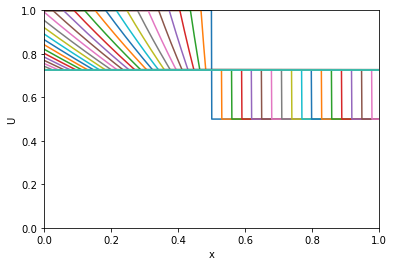

In [176]:
# Initialiesierung der Werte:
hl= 1
hr = 0.5
x0 = 0.5
g= 9.81

#temporär: (Ersetzen mit Anfangsbedingungen, dann müsste t in Anfangsbedingungen ergänzt werden)
x = np.linspace(0, 1, 1000)
t = np.linspace(0, 1, 100)



# Sw bestimmen
def f(Sw):
    return Sw - (g*hr)/(4*Sw)*(1+np.sqrt(1+(8*Sw**2)/(g*hr))) + 2*np.sqrt((g*hr)/2*(np.sqrt(1+(8*Sw**2)/(g*hr))-1)) - 2*np.sqrt(g*hl)
z = 1
while True:
    Sw = optimize.newton(f, z) # Validierung des positiven ergebnisses
    z += 1
    if Sw > 0:
        break


h,u = dammbruch(x,t,x0,hl,hr,Sw)
#print(h[:,1])

fig, ax = plt.subplots()
for n in range(h.shape[1]):
        ax.plot(x, h[:,n])
ax.set_xlabel('x')
ax.set_ylabel('U')
ax.title.set_fontsize(13)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

# Vielleicht Animation daraus machen?
# Komisch, dass auf der "rechten Seite" es so eckig ist, aber in der h Funktion zwischen xb und xc ist weder x noch t in der Rechnung integriert, also muss es eine Konstante sein (0.75...).

[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
dt = 0.0031927542840705044


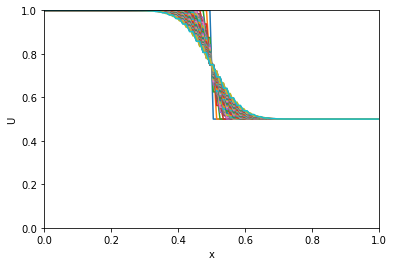

In [42]:
# Initialisierung der Werte:
hl= 1
hr = 0.5
x0 = 0.5
g= 9.81
CFL = 1 # Wie groß ist CFL?
Nx = 100
Nt = 50

# temporär: (Ersetzen mit Anfangsbedingungen, dann müsste t in Anfangsbedingungen ergänzt werden)
x = np.linspace(0, 1, Nx) # wird nur für anfangsbedingung verwendet, könnte umprogrammiert werden
t = np.linspace(0, 1, Nt) #wird nicht gebraucht
dx = 1/Nx

# Anfangsbedingungen
h = np.zeros((Nx, Nt), dtype= float)
u = np.zeros((Nx, Nt), dtype= float)
# Randbedingungen vielleicht noch sauberer 0.5 ist 1 und 0.5 gleichzeitig
h[:,0] = np.where(x>=0.5, 0.5, 1)
#print(h[:,0])

# Zeitschritt bestimmen (Viele berechnungen die sich doppeln)
EV = np.array([u[0,0]-np.sqrt(g*h[0,0]), u[0,0]-np.sqrt(g*h[0,0])])
for i in range(1,Nx):
    EV = np.append(EV,[u[i,0]-np.sqrt(g*h[i,0]), u[i,0]+np.sqrt(g*h[i,0])])
dt = CFL * dx/(np.amax(EV))
print("dt =", dt)


# Wände berechnen
F_j12 = np.zeros((Nx-1,Nt),dtype= float)
for k in range(0, Nt-1):
    for j in range(0,Nx-1):
        F_j12[j,k] = 0.5*dx/dt*(h[j,k] - h[j+1,k]) + 0.5*(h[j,k]*u[j,k] + h[j+1,k]*u[j+1,k])
    #print(h[:,1])
    #print(F_j12[:,k])
    for l in range(1,Nx-1):
        h[l,k+1] = h[l,k] - dt/dx*(F_j12[l,k] - F_j12[l-1,k])
        # u erneuern?
    # Randbedingungen reflektierend
    u[0,k+1] = u[1,k+1]
    u[Nx-1,k+1] = u[Nx-2,k+1]
    h[0,k+1] = h[1,k+1]
    h[Nx-1,k+1] = h[Nx-2,k+1]


# h plotten
fig, ax = plt.subplots()
for n in range(h.shape[1]):
        ax.plot(x, h[:,n])
ax.set_xlabel('x')
ax.set_ylabel('U')
ax.title.set_fontsize(13)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

# Bei verschiedenen Netzauflösungen Zeitpunkt T = 0.1

